Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC

In [ ]:
!wget http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz

--2021-06-08 09:35:48--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz [following]
--2021-06-08 09:35:48--  https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘WISDM_ar_latest.tar.gz’

WISDM_ar_latest.tar 100%[===================>]  10.88M  14.6MB/s    in 0.7s    

2021-06-08 09:35:49 (14.6 MB/s) - ‘WISDM_ar_latest.tar.gz’ saved [11404612/11404612]



In [ ]:
!ls 

sample_data  WISDM_ar_latest.tar.gz


In [ ]:
!tar -xvzf  WISDM_ar_latest.tar.gz

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [ ]:
!ls WISDM_ar_v1.1

readme.txt		     WISDM_ar_v1.1_trans_about.txt
WISDM_ar_v1.1_raw_about.txt  WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1_raw.txt


# testing basic copy of code


In [ ]:

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils


In [ ]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 128
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 32

keras version  2.5.0


In [ ]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [ ]:
# Describe the data
show_basic_dataframe_info(df)
df.head(5)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


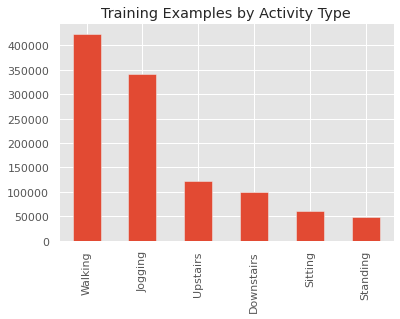

In [ ]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()


In [ ]:
print (df['activity'].value_counts())

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


In [ ]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [ ]:
#normalizing input variables for entire dataset
pd.options.mode.chained_assignment = None  # default='warn'
df['x-axis'] = df['x-axis'] / df['x-axis'].max()
df['y-axis'] = df['y-axis'] / df['y-axis'].max()
df['z-axis'] = df['z-axis'] / df['z-axis'].max()
# Round numbers
df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [ ]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Differentiate between test set and training set
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_data, y_data = create_segments_and_labels(df,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

#df_test = df[df['user-id'] > 28]
#df_train = df[df['user-id'] <= 28]
print (x_data.shape)
print(y_data.shape)

(34315, 128, 3)
(34315,)


In [ ]:
print(type(x_data))

<class 'numpy.ndarray'>


In [ ]:
#deviding dataset into 70 % (train) and 30% test chuncks
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(24020, 128, 3) (24020,)
(10295, 128, 3) (10295,)


In [ ]:
#further saving 15 % from the total of 30 % test data into cross and test 
X_cross, X_test, y_cross, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_cross.shape, y_cross.shape)
print(X_test.shape, y_test.shape)

(5147, 128, 3) (5147,)
(5148, 128, 3) (5148,)


In [ ]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')
y_train = np_utils.to_categorical(y_train, num_classes)
print('y_train shape: ', y_train.shape)

X_train shape:  (24020, 128, 3)
24020 training samples
y_train shape:  (24020, 6)


In [ ]:
print('X_test shape: ', X_test.shape)
print(X_test.shape[0], 'testing samples')
y_test = np_utils.to_categorical(y_test, num_classes)
print('y_test shape: ', y_test.shape)

X_test shape:  (5148, 128, 3)
5148 testing samples
y_test shape:  (5148, 6)


In [ ]:
print('X_cross shape: ', X_cross.shape)
print(X_cross.shape[0], 'cross samples')
y_cross = np_utils.to_categorical(y_cross, num_classes)
print('y_cross shape: ', y_cross.shape)

X_cross shape:  (5147, 128, 3)
5147 cross samples
y_cross shape:  (5147, 6)


##my model


In [ ]:
from keras import models
from keras.models import Model
from keras.layers import Input
import tensorflow
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
from keras.layers import add
from keras.layers import Activation
from keras.layers import GRU
from keras.layers import LSTM, Bidirectional, BatchNormalization

In [ ]:
def inception_network(trainX, trainy):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  input_shape=(n_timesteps,n_features)
  #first two signals
  signal_input = Input(shape=input_shape, name='data')
  gru1=Bidirectional(GRU(64,return_sequences=True))(signal_input)
  bn=BatchNormalization()(gru1)
  layer_1_a = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu',name='1x1_a_3')(bn) #with 1x1 conv
  layer_1_a = Conv1D(filters=10,  kernel_size=3, padding='same', activation='relu',name='1x3_a')(layer_1_a) # with 1x3 

  layer_2_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu',name='1x1_a_5')(bn) #with 1x1
  layer_2_a = Conv1D(10,  kernel_size=5, padding='same', activation='relu',name='1x5_a')(layer_2_a)#with 1x5

  layer_3_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu',name='1x1_a_7')(bn) #with 1x1
  layer_3_a = Conv1D(10,  kernel_size=7, padding='same', activation='relu',name='1x7_a')(layer_3_a) #with 1x7

  layer_1_direct = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu',name='1x1_a_direct')(bn) #with 1x1 conv

  layer_4_b = MaxPooling1D(pool_size=1, padding='same',name='MaxPool_b_1')(bn) # pooling
  layer_4_b = Conv1D(10,  kernel_size=1, padding='same', activation='relu',name='MaxPool_1x1_b')(layer_4_b) # with 1x1

  mid_1_a = keras.layers.concatenate([layer_1_a, layer_2_a,layer_3_a,layer_1_direct,layer_4_b], axis = 2)
  drop2=Dropout(0.5)(mid_1_a)
  #<------------------------------------------------------------Concatenated Module 1 with input---------------------->
  #<-----1x1 x64 layer ----->
  mid_1_a=Conv1D(filters=32,  kernel_size=1, padding='same', activation='relu',name='a_1x1_size_reduce')(drop2) 
  mid_1_a=Conv1D(filters=16,  kernel_size=1, padding='same', activation='relu',name='a_1x1_size_reduce')(drop2) 
  mid_1_a=Conv1D(filters=8,  kernel_size=1, padding='same', activation='relu',name='a_1x1_size_reduce')(drop2) 

  #<-----Ending network ----->
  before_flat=Conv1D(filters=6,  kernel_size=1, padding='same', activation='relu',name='before_2_1x1_size_reduce')(mid_1_a)
  
  globelAverage=keras.layers.GlobalAveragePooling1D(data_format='channels_last')(before_flat)
  
  out = Dense(n_outputs, activation='softmax', name='predictions')(globelAverage)
  
  rez = Model(inputs=signal_input, outputs=out)
  
  return rez

In [ ]:
model=inception_network(X_train, y_train)

In [ ]:
print (model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128, 128)     26496       data[0][0]                       
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128)     512         bidirectional_3[0][0]            
__________________________________________________________________________________________________
1x1_a_3 (Conv1D)                (None, 128, 10)      1290        batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [ ]:
inception= model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

In [ ]:
import datetime
begin_time = datetime.datetime.now()
verbose, epochs, batch_size = 0, 80, 120 # here are the parameters of training verbose, epoch, batchSize
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)#, verbose=1,callbacks=[es])
print(datetime.datetime.now() - begin_time)

# evaluate model

Epoch 1/80
201/201 [==============================] - 10s 29ms/step - loss: 1.4416 - accuracy: 0.4345 - val_loss: 1.0870 - val_accuracy: 0.6626
Epoch 2/80
201/201 [==============================] - 4s 20ms/step - loss: 0.6094 - accuracy: 0.7846 - val_loss: 0.6587 - val_accuracy: 0.7566
Epoch 3/80
201/201 [==============================] - 4s 20ms/step - loss: 0.5307 - accuracy: 0.8089 - val_loss: 0.5162 - val_accuracy: 0.7822
Epoch 4/80
201/201 [==============================] - 4s 22ms/step - loss: 0.4264 - accuracy: 0.8339 - val_loss: 0.4842 - val_accuracy: 0.8129
Epoch 5/80
201/201 [==============================] - 4s 20ms/step - loss: 0.3893 - accuracy: 0.8505 - val_loss: 0.4405 - val_accuracy: 0.8273
Epoch 6/80
201/201 [==============================] - 4s 22ms/step - loss: 0.3677 - accuracy: 0.8632 - val_loss: 0.3481 - val_accuracy: 0.8786
Epoch 7/80
201/201 [==============================] - 4s 20ms/step - loss: 0.3244 - accuracy: 0.8813 - val_loss: 0.3861 - val_accuracy: 0.872

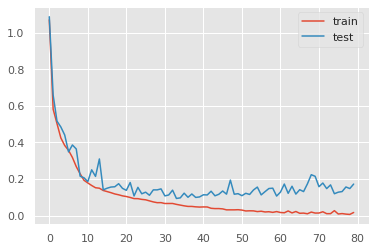

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

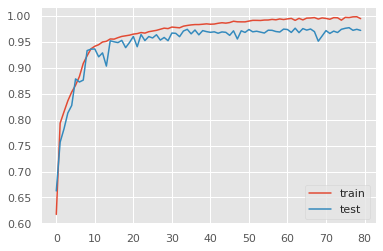

In [ ]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
_, accuracy = model.evaluate(X_cross, y_cross, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  97.62969017028809


In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  97.20279574394226


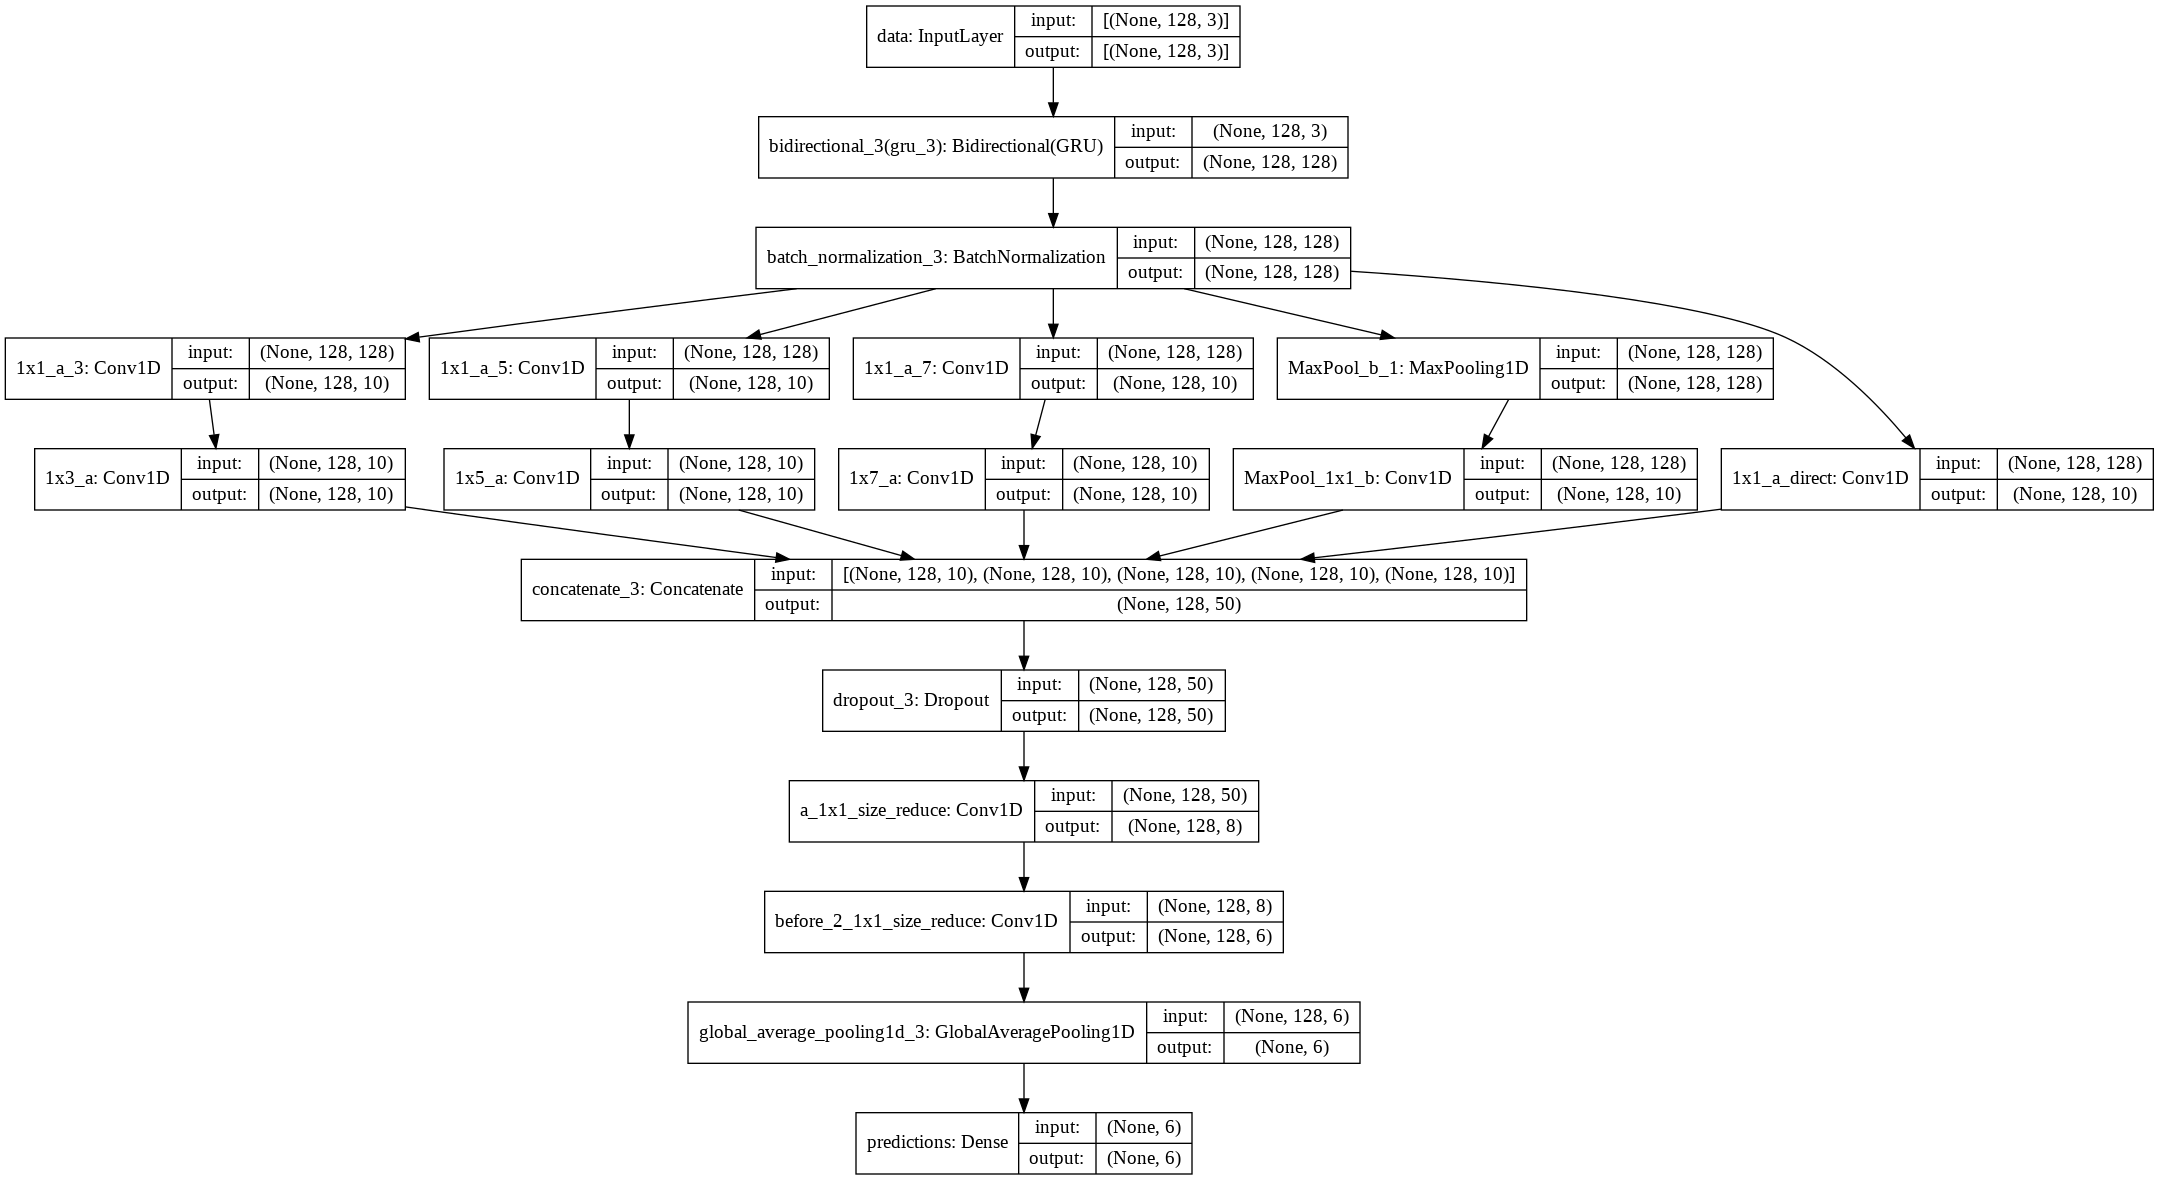

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred,normalize="true")
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(6, 6))
    ax = sn.heatmap(df_cm, annot=True, square=True, linewidths=.2,cmap="YlGnBu" ,cbar_kws={"shrink": 0.8})
    return ax

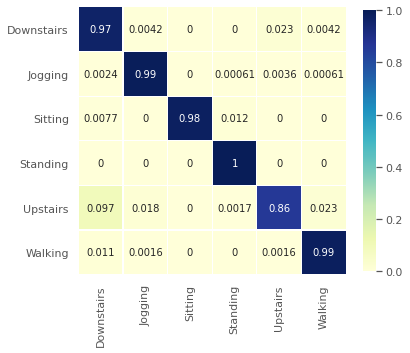

In [ ]:
y_pred=model.predict(X_test)
plot_confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels)

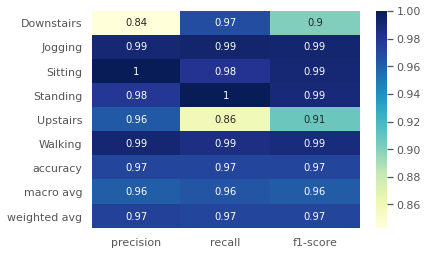

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
y_pred=model.predict(X_test)
report= classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=labels,output_dict=True)
#print (report)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, cmap="YlGnBu",annot=True)

In [ ]:
model.save('UltaNet_ActivityPrediction.h5') 

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = len(labels)
#print (n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


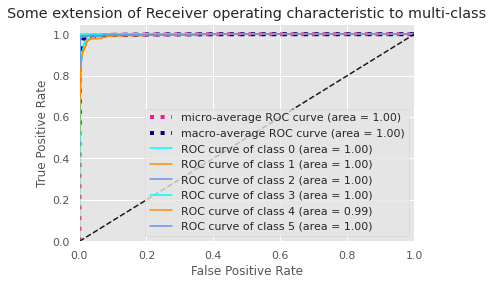

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()